In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import scipy
from numba import njit, jit
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# how to get context
* feed in downdsampled whole image with subsample - put at layer in 3dcnn, make a fork with subsample and downsample at top
* physics things
* 3 frame thing - would need to stabalize video
* get vector field, get most common vector, use that as an input

# things to try:
* run the val and test through the bootstrapping, remove the test_data because we're using our eyes anyways
* see how much faster it runs on 20 x 20 images
* 

In [2]:
from IPython.display import Audio, display

url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"


def allDone():
    display(Audio(url=url_done, autoplay=True,))

In [3]:
data_dir = os.path.join(os.getcwd(), "data")
drone_dir = os.path.join(data_dir, "tir_pavel")

In [4]:
video_files = ["pavel0.npy", "pavel1.npy", "pavel2.npy", "pavel3.npy"]

video_np = []
for file in video_files:
    video_np.append(np.load(os.path.join(drone_dir, file)))

In [5]:
import datetime as dt


timestamp_files = [
    "timestamp0.npy",
    "timestamp1.npy",
    "timestamp2.npy",
    "timestamp3.npy",
]

timestamp_np = []
for file in timestamp_files:
    timestamp_np.append(np.load(os.path.join(drone_dir, file)).squeeze())


def md(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum % 1) - dt.timedelta(days=366)
    return pd.Timestamp(day + dayfrac).round("S")


matlab_to_date = np.vectorize(md)
timestamp_np = map(matlab_to_date, timestamp_np)

In [6]:
video_dfs = []
for video, timestamp in zip(video_np, timestamp_np):
    video_dfs.append(pd.DataFrame({"frames": [*video]}))
    video_dfs[-1].index = timestamp

video_dfs[0]

,frames
2019-08-06 12:29:34,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:35,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:36,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:37,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:38,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...
2019-08-06 12:48:33,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:34,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:35,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:36,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


#### merging the two:

making the data more coarse: 
* https://stackoverflow.com/a/39952846/6293070
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html 
* we probably want to resample down to half seconds? and take that average?

merging the two:
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html#pandas.merge_asof
* https://stackoverflow.com/a/43979285/6293070
    

In [7]:
label_df_1 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_1"), "/df")
label_df_2 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_2"), "/df")
label_df = pd.concat([label_df_1, label_df_2], axis=0)
print(label_df.shape)

(503881, 29)


In [8]:
label_df = label_df.resample("1S").mean()
print(label_df.shape)

(1924190, 29)


In [9]:
print(pd.Timedelta("5S"))
print(pd.Timedelta("500L"))

0 days 00:00:05
0 days 00:00:00.500000


In [10]:
videos_w_labels = []
for video_df in video_dfs:
    videos_w_labels.append(
        pd.merge_asof(
            video_df,
            label_df,
            left_index=True,
            right_index=True,
            tolerance=pd.Timedelta("3S"),
            direction="nearest",
        )
    )

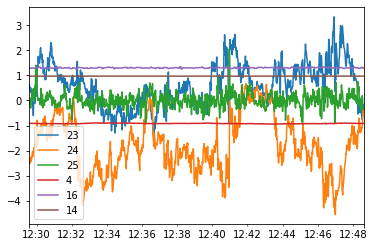

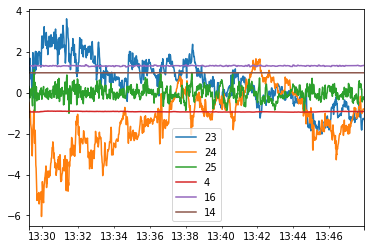

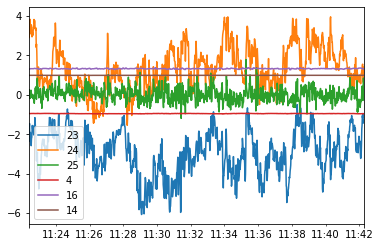

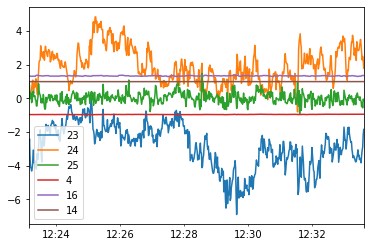

In [11]:
for df in videos_w_labels:
    #     print(df.mean(axis=0, numeric_only=True))
    df[[23, 24, 25, 4, 16, 14]].plot()

# Getting video and labels out of dataframe
* get out one thing for the labels, on thing for the video
* make sure that the video is just a 3d nparray

In [12]:
labels = [23, 24]

label_np = []
for video_w_label in videos_w_labels:
    label_np.append(video_w_label[labels].to_numpy())

In [13]:
# pavel_data_dir = os.path.join(data_dir, "pavel_data")
# for i, (label, video) in enumerate(zip(label_np, video_np)):
#     np.save(os.path.join(pavel_data_dir, "label_" + str(i) + ".npy"), label)
#     np.save(os.path.join(pavel_data_dir, "video_" + str(i) + ".npy"), video)

Somehow take the center of this:

for now just take width and height from shape
divide it by four

then take the middle half

In [14]:
# might not be the right order!


def get_middle(a):
    video0 = a
    frames, height, width = video0.shape

    cut_off = 4

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    video0 = video0[:, top:bottom, left:right]
    return video0

In [15]:
def replace_nan_with_mean(a):
    return np.where(np.isnan(a), np.ones_like(a) * np.nanmean(a), a)

detrending:
* take 30 seconds of video
* wow so detrend...
* for every frame find median value
* everything above median is white (1), everything below is black(0)

see if it works with a 40 by 40 square

(628, 436, 496)
(1144, 436, 496)
(1144, 218, 248)
(1122, 436, 496)
(1122, 218, 248)
(1193, 436, 496)
(1193, 218, 248)
(628, 436, 496)
(628, 218, 248)


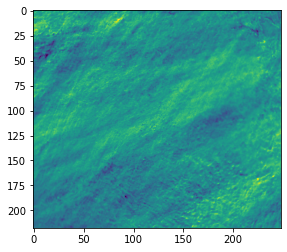

In [16]:
from scipy import signal
from functools import partial
from skimage.transform import rescale

print(video.shape)


def get_frame_middle(frame, cut_off):
    a = frame
    height, width = a.shape

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    return a[top:bottom, left:right]


@njit
def median_mask(b, n_dev):
    a = b
    std = np.std(a) * n_dev
    median = np.median(b)
    a = np.where(a < median - std, median - std, a)
    a = np.where(a > median + std, median + std, a)
    return a


def moving_average(video, window_size):
    secs = np.arange(0, video.shape[0])
    mavgl = []
    for i in secs:
        if i >= window_size:
            mavgl.append(np.nanmean(video[i - window_size : i, :, :], axis=0))
        else:
            mavgl.append(np.nanmean(video[: i + 1, :, :], axis=0))
    return np.stack(mavgl, axis=0)


def sigmoid(a):
    a = 1 / (1 + np.exp(-a))
    return a


@njit
def subtract_median(a):
    a = a - np.median(a)
    return a


@njit
def subtract_from_frame(a, sub):
    a = a - sub
    return a


@njit
def divide_by_std(a):
    a = a / a.std()
    return a


def apply_to_outer_axis(a, func, args=[]):
    b = a
    for i in range(len(b)):
        b[i] = func(b[i], *args)
    #         b = np.put(b, i, func(b[i], *args))
    return b


def apply_funcs_to_outer_axis(a, funcs):
    """
    args:
    a: thing to apply over
    funcs: list of functions to apply over, can take args
        for example:
            funcs = [f_a, f_b]
            funcs = [(f_a, [1,2,3]), (f_b, [1])]
        a functions with args should be a pair with the args as a list
    """
    for i, f in enumerate(funcs):
        if callable(f):
            funcs[i] = (f, [])

    b = []
    for i in range(a.shape[0]):
        b.append(a[i])
        for f, args in funcs:
            b[i] = f(b[i], *args)
    return np.stack(b, axis=0)


# UNTESTED
def five_crop(video):
    print(video.shape)
    # 1144, 436, 496 UNTESTED
    _, h, w = video.shape
    hh = h // 2
    hw = w // 2
    a = video[:, :hh, :hw]
    b = video[:, hh:, :hw]
    c = video[:, :hh, hw:]
    d = video[:, hh:, hw:]
    e = get_middle(video)
    plt.imshow(a[0])
    plt.imshow(b[0])
    plt.imshow(c[0])
    plt.imshow(d[0])
    plt.imshow(e[0])
    return a, b, c, d, e


def get_sub_video(video, x, y, size):
    hs = size // 2
    return video[:, x - hs : x + hs, y - hs : y + hs]


videos_processed = []
for video in video_np:
    print(video.shape)
    video = replace_nan_with_mean(video)
    video = get_middle(video)
    _, h, w = video.shape
    #     video = get_sub_video(video, h // 2, w // 2, 20)
    video = (video - np.median(video)) / video.std()
    video = scipy.signal.detrend(video, axis=0)
    video = moving_average(video, 3)
    video = apply_to_outer_axis(video, subtract_median)
    video = apply_to_outer_axis(video, np.tanh)
    video = apply_to_outer_axis(video, median_mask, [2])
    video = apply_to_outer_axis(video, divide_by_std)
    #     #     b = []
    #     #     for i in range(video.shape[0]):
    #         b.append(rescale(video[i], 0.5, anti_aliasing=False))
    #     video = np.stack(b, axis=0)
    videos_processed.append(video)
    print(videos_processed[-1].shape)


plt.imshow(np.mean(video, axis=0))

# sucessfull video pre-processing stacks
* subtract_median, sigmoid, detrend_all, median_mask
* subtract_median, sigmoid, detrend_all, median_mask(2nd dev)

# how to get more from the data set
* take subsamples, move the labels in time so that they are where the subsample was taken (use an autocorrelation to figure out the timelag between a portion of the greater image and the wind sensor)
* take subsamples near the center (quarters near the center of the image?)

# reorg
* make 'sub' function that pulls a chunk of pixels out of a frame that you call form everywhere, this will allow you to change shape of your input without much of a headache, this way you can do :,x:y,a:b,: for a 5d case (0 being batch) and then just take out the first : to get it down to a 4d case.

In [17]:
def Tensor_to_video(Tensor, path):
    Tensor = tf.where(
        tf.math.is_nan(Tensor),
        tf.ones_like(Tensor) * np.nanmean(Tensor.numpy()),
        Tensor,
    )
    video = tf.cast(255 * min_max_norm(Tensor), tf.uint8)
    frames, width, height = video.shape
    _fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(path, _fourcc, 10, (width, height))
    for i in range(frames):
        img = video[i, :, :]
        img = tf.repeat(tf.expand_dims(tf.transpose(img), axis=-1), 3, axis=2).numpy()
        out.write(img)


def min_max_norm(Tensor):
    min = tf.reduce_min(Tensor)
    max = tf.reduce_max(Tensor)
    return (Tensor - min) / (max - min)


# for i, video in enumerate(videos_processed):
#     video_path = os.path.join(data_dir, "videos", "center_video" + str(i) + ".mp4")
#     Tensor_to_video(tf.convert_to_tensor(video), video_path)

# from IPython.display import Video

# video_path = os.path.join(data_dir, "videos", "center_video.mp4")
# Video(video_path)

# allDone()

# things to try:
* how much to downsample?
* does our pre-processing do anything?
<!-- * do we need the whole image -->

In [18]:
output_size = 20

In [19]:
videos = videos_processed
videos = [x.astype("float32") for x in videos]

In [20]:
print(videos[0].shape)

(1144, 218, 248)


In [21]:
# video = np.stack(np.atleast_3d(*video), axis=0)


def add_axis_to_frames(a):
    return np.stack(np.atleast_3d(*a), axis=0)


videos = list(map(add_axis_to_frames, videos))

# ways to shape the data:
* one big list for everything
* 3d video chunks with a few consecutive frames

In [22]:
labels = [23, 24]

label_np = []
for video_w_label in videos_w_labels:
    label_np.append(video_w_label[labels].to_numpy())

In [23]:
clockwise_90 = np.array([[0, 1], [-1, 0]])


def rotate_90(arr):
    return arr @ clockwise_90


label_np = apply_to_outer_axis(label_np, rotate_90)

In [24]:
window_size = 2


def remove_window_head(x, window_size):
    return x[window_size - 1 :]


def get_sub_videos(video, window_size):
    a = np.lib.stride_tricks.sliding_window_view(video, window_size, axis=0)
    return np.moveaxis(a, 4, 1)


label_np = apply_to_outer_axis(label_np, remove_window_head, [window_size])
videos = apply_to_outer_axis(videos, get_sub_videos, [window_size])

In [25]:
# one big list
video = np.concatenate(videos, axis=0)
labels = np.concatenate(label_np, axis=0)

In [26]:
print(video.shape, labels.shape)

(4083, 2, 218, 248, 1) (4083, 2)


# 3d conv net making things
* take stacks of 3 with a stride of 1
* take the average of the labels
* stick them together onto a new axis
* stick all of the threes together

In [27]:
from numpy.random import default_rng


def shuffle_arrays(a, b):
    assert a.shape[0] == b.shape[0]
    length = a.shape[0]
    x = a
    y = b
    rng = default_rng()
    idx = rng.choice(length, length)
    x = x[idx]
    y = y[idx]
    return x, y


def chunk_idx_shuffle(a, blocksize):
    idx = np.arange(a.shape[0])
    blocks = [
        idx[i * blocksize : (i + 1) * blocksize] for i in range(len(idx) // blocksize)
    ]
    random.shuffle(blocks)
    return [elt for block in blocks for elt in block]


def shuffle_chunks_arrays(a, b, chunk_size):
    assert a.shape[0] == b.shape[0]
    idx = chunk_idx_shuffle(a, chunk_size)
    x = a
    y = b
    x = x[idx]
    y = y[idx]
    return x, y


# video, labels = shuffle_by_blocks(labels, 10)
# x_train, y_train = shuffle_arrays(x_train, y_train)
video, labels = shuffle_chunks_arrays(video, labels, 10)
# video, labels = shuffle_arrays(video, labels)

In [28]:
print(video.shape)
print(labels.shape)

(4080, 2, 218, 248, 1)
(4080, 2)


In [29]:
def train_val_test(train, val, test, X, y):
    assert train + val + test == 1
    data_len = len(X)
    train_size = int(train * data_len)
    val_size = int(val * data_len)
    test_size = int(test * data_len)

    splits = [
        (0, train_size),
        (train_size, train_size + val_size),
        (train_size + val_size, data_len),
    ]

    x_out = []
    y_out = []
    for a, b in splits:
        x_out.append(X[a:b])
        y_out.append(y[a:b])

    return (*x_out, *y_out)


x_train, x_val, x_test, y_train, y_val, y_test = train_val_test(
    0.8, 0.2, 0.0, video, labels
)

# video cropping
* make 5crop
* take subsection of video (from center)
* take the middle and the corners
* return them as a list

In [30]:
@njit
def sub_data(x, a=None, b=None, c=None, d=None):
    return x[:, :, a:b, c:d, :]


@njit
def sub_vid(x, a=None, b=None, c=None, d=None):
    return x[:, a:b, c:d, :]


@njit
def sub_pic(x, a=None, b=None, c=None, d=None):
    return x[a:b, c:d, :]


@njit
def get_frame(x, frame):
    return x[frame]


# @njit
def get_center(x, size):
    if len(x.shape) == 5:
        _, _, h, w, _ = x.shape
        func = sub_data
    elif len(x.shape) == 4:
        _, h, w, _ = x.shape
        func = sub_vid
    elif len(x.shape) == 3:
        h, w, _ = x.shape
        func = sub_pic
    else:
        raise ValueError("unsupported dims")
    hh = h // 2
    hw = w // 2
    hs = size // 2
    return func(x, hh - hs, hh + hs, hw - hs, hw + hs)


@njit
def five_crop(frame, macro, micro):
    h, w, _ = frame.shape
    hh = h // 2
    hw = w // 2
    h_macro = macro // 2
    frame = frame[hh - h_macro : hh + h_macro, hw - h_macro : hw + h_macro, :]
    a = frame[:micro, :micro, :]
    b = frame[macro - micro :, :micro, :]
    c = frame[:micro, macro - micro :, :]
    d = frame[macro - micro :, macro - micro :, :]
    e = frame[macro - micro : macro + micro, macro - micro : macro + micro, :]
    return [a, b, c, d, e]


@njit
def random_subcrops(frame, macro, micro, num):
    for x in frame.shape[1:2]:
        assert x > macro
    assert micro <= macro
    _, h, w, _ = frame.shape
    hh = h // 2
    hw = w // 2
    h_micro = micro // 2
    h_macro = macro // 2

    h_max = hh + h_macro - h_micro
    h_min = hh - h_macro + h_micro
    w_max = hw + h_macro - h_micro
    w_min = hw - h_macro + h_micro

    sub_frames = []
    for _ in range(num):
        h = int(random.uniform(h_min, h_max))
        w = int(random.uniform(w_min, w_max))
        sub_frame = sub_vid(frame, h - h_micro, h + h_micro, w - h_micro, w + h_micro)
        sub_frames.append(sub_frame)
    return sub_frames


@njit
def random_flip(a, b):
    x, y = a, b
    r = random.random()

    if r < 0.25:
        pass
    elif r >= 0.25 and r < 0.5:
        x = x[:, ::-1, :, :]
        y = y * np.array([-1, 1])
    elif r >= 0.5 and r < 0.75:
        x = x[:, :, ::-1, :]
        y = y * np.array([-1, 1])
    elif r >= 0.75:
        x = x[:, ::-1, ::-1, :]
        y = y * np.array([-1, -1])

    return (x, y)


def apply_to_outer_axes(a, b, func, args=[]):
    x, y = a, b
    assert len(x) == len(y)
    for i in range(len(x)):
        x[i], y[i] = func(x[i], y[i], *args)
    return x, y


def get_repeated_main(x_train, x_macro_train, y, num_resample, size):
    x = a
    for i in range(len(x)):
        macro = get_frame(x[i], window_size - 1)
        macro = get_center(macro, size)
        for _ in range(num_resample):
            yield macro


def data_generator(a, b, macro_size, num_resample):
    x, y = a, b
    for i, frame in enumerate(x):
        macro = get_frame(x[i], window_size - 1)
        macro = get_center(macro, macro_size)

        crops = random_subcrops(frame, 40, output_size, num_resample)
        for crop in crops:
            micro, label = random_flip(crop, y[i])

            micro = tf.convert_to_tensor(micro, dtype=tf.float32)
            macro = tf.convert_to_tensor(macro, dtype=tf.float32)
            label = tf.convert_to_tensor(label, dtype=tf.float32)

            yield {"micro": micro, "macro": macro}, label


def get_dataset(x, y):
    return tf.data.Dataset.from_generator(
        data_generator,
        args=[x_train, y_train, macro_size, num_resample],
        output_signature=(
            {
                "micro": tf.TensorSpec(shape=micro_shape, dtype=tf.float32),
                "macro": tf.TensorSpec(shape=macro_shape, dtype=tf.float32),
            },
            tf.TensorSpec(shape=label_shape, dtype=tf.float32),
        ),
    )


num_resample = 30
macro_size = 200
micro_shape = (window_size, output_size, output_size, 1)
macro_shape = (macro_size, macro_size, 1)
label_shape = (2,)

train_dataset = get_dataset(x_train, y_train)
val_dataset = get_dataset(x_val, y_val)
test_dataset = get_dataset(x_test, y_test)

In [31]:
# these take a really long time to run

# elem = next(iter(train_dataset))
# x, y = elem
# assert micro_shape == x["micro"].shape
# assert macro_shape == x["macro"].shape
# assert label_shape == y.shape
# elem = next(iter(val_dataset))
# x, y = elem
# assert micro_shape == x["micro"].shape
# assert macro_shape == x["macro"].shape
# assert label_shape == y.shape

# notes
* does worse if we shuffle the train after a chunk shuffle

In [32]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# takes forever to run...

# elem = next(iter(train_dataset))
# x, y = elem
# print(x["micro"].shape)

# elem = next(iter(val_dataset))
# x, y = elem
# print(x["micro"].shape)

(64, 2, 20, 20, 1)


In [ ]:
tf.random.set_seed(1234)

In [ ]:
drop_rate = 0.2
batch_size = 64
print(micro_shape)
print(macro_shape)

micro_input = tf.keras.Input(shape=micro_shape, name="micro")
macro_input = tf.keras.Input(shape=macro_shape, name="macro")

micro = micro_input
macro = macro_input

micro = tf.keras.layers.BatchNormalization()(micro)
micro = tf.keras.layers.ConvLSTM2D(
    30, 6, activation="relu", dropout=drop_rate, padding="same",
)(micro)
micro = tf.keras.layers.MaxPooling2D(pool_size=3)(micro)
micro = tf.keras.layers.BatchNormalization()(micro)
micro = tf.keras.layers.Flatten()(micro)

macro = tf.keras.layers.BatchNormalization()(macro)
macro = tf.keras.layers.Conv2D(30, 20, strides=5, activation="relu")(macro)
macro = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(macro)
macro = tf.keras.layers.BatchNormalization()(macro)
macro = tf.keras.layers.Conv2D(20, 5, activation="relu")(macro)
macro = tf.keras.layers.MaxPooling2D(pool_size=3)(macro)
macro = tf.keras.layers.BatchNormalization()(macro)
macro = tf.keras.layers.Flatten()(macro)

pred = tf.keras.layers.concatenate([macro, micro])
pred = tf.keras.layers.Dense(50, activation="relu")(pred)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
pred = tf.keras.layers.Dense(50, activation="relu")(pred)
pred = tf.keras.layers.Dense(2, name="output")(pred)

model = tf.keras.Model(inputs=[macro_input, micro_input], outputs=[pred],)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    metrics=["mean_absolute_error", "mean_squared_error"],
)
# model.summary()
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True, dpi=227)

In [ ]:
monitor_param = "val_mean_squared_error"


nan_terminate = tf.keras.callbacks.TerminateOnNaN()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor_param, patience=3)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_param, patience=5  # , restore_best_weights=True
)


checkpoint_filepath = os.path.join(data_dir, "model_checkpoints", "checkpoint")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor_param,
    mode="min",
    save_best_only=True,
)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, checkpoint, nan_terminate],
)

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
# model.evaluate(x=x_test, y=y_test)
# model.evaluate(test_dataset)

In [ ]:
# preds = model.predict(x=x_test)
# preds = model.predict(x=x_train)
# preds = model.predict(test_dataset)

In [ ]:
# print(preds.shape, y_test.shape)
# print(preds.shape, y_train.shape)

In [ ]:
def unstack(a, axis=1):
    return np.moveaxis(a, axis, 0)


def plot(l, r, preds, labels, width=20, height=7):
    assert len(preds[0].shape) == len(labels[0].shape)
    preds = preds[l:r, :]
    labels = labels[l:r, :]
    preds = unstack(preds)
    labels = unstack(labels)
    x = list(range(len(preds[0])))
    plt.rcParams["figure.figsize"] = [width, height]
    for i, label in enumerate(labels):
        plt.scatter(x, label, label="labels_" + str(i))
    for i, pred in enumerate(preds):
        plt.scatter(x, pred, label="predictions_" + str(i))
    plt.legend()
    plt.show()


# plot(69, 420, preds, y_test)

# making vector fiels
* break up the images in the video
* feed them into the model
* get u and v
* stick u and v onto the picture
* turn the picture into a video?

# how to use the shady vector field code
* for one, it doesn't work right now, something looks flipped or rotated
* but if you want to use it anyways
* train the neural net on the pic size you want to be able to get the vectors out of
* go back up and remake the video into it's full size and length
* run this code

In [ ]:
@njit
def get_sub_pic(pic, x, y, size):
    hs = size // 2
    return pic[:, x - hs : x + hs, y - hs : y + hs, :]


def arrow_data_generator(a, b, xs, ys, macro_size, num_resample):
    for i, (frames, label) in enumerate(zip(a, b)):
        macro = frames
        macro = get_frame(macro, window_size - 1)
        macro = get_center(macro, macro_size)

        for x, y in zip(xs, ys):
            micro = get_sub_pic(frames, x, y, pic_size)

            micro = tf.convert_to_tensor(micro, dtype=tf.float32)
            macro = tf.convert_to_tensor(macro, dtype=tf.float32)
            label = tf.convert_to_tensor(label, dtype=tf.float32)

            yield {"micro": micro, "macro": macro}, label


frames_idx = list(range(0, video.shape[0], 100))
y_arrows = 7
x_arrows = 7
pic_size = output_size


_, _, x_size, y_size, _ = video.shape
x_idx = np.linspace(0, x_size, x_arrows + 2)[1:-1].astype(int)
y_idx = np.linspace(0, y_size, y_arrows + 2)[1:-1].astype(int)

print(y_idx)
print(y_size)


xv, xy = np.meshgrid(x_idx, y_idx)
xs = xv.flatten()
ys = xy.flatten()
x = video[frames_idx]
y = labels[frames_idx]

arrow_gen_dataset = tf.data.Dataset.from_generator(
    arrow_data_generator,
    args=[x, y, xs, ys, macro_size, num_resample],
    output_signature=(
        {
            "micro": tf.TensorSpec(shape=micro_shape, dtype=tf.float32),
            "macro": tf.TensorSpec(shape=macro_shape, dtype=tf.float32),
        },
        tf.TensorSpec(shape=label_shape, dtype=tf.float32),
    ),
).batch(BATCH_SIZE)


uvs = model.predict(arrow_gen_dataset)
uvs = np.split(uvs, len(frames_idx))

plot_dir = os.path.join(data_dir, "plots")

for uv, frame, idx in zip(uvs, x, frames_idx):
    u = uv[:, 1]
    v = uv[:, 0]
    plt.figure(figsize=(7, 7))
    plt.imshow(frame[window_size - 1, :, :, 0], origin="upper")
    plt.quiver(ys, xs, u, v, color="red")
    #     plt.savefig(os.path.join(plot_dir, "quiver" + str(idx) + ".png"))
    plt.show()


allDone()